In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [ ]:
# Load dataset

data = pd.read_csv("/landslide_dataset.csv")
data.head()

,Rainfall_mm,Slope_Angle,Soil_Saturation,Vegetation_Cover,Earthquake_Activity,Proximity_to_Water,Landslide,Soil_Type_Gravel,Soil_Type_Sand,Soil_Type_Silt
0,206.181018,58.275001,0.892798,0.339463,4.390047,0.099975,1,0,0,0
1,218.887334,36.679801,0.657147,0.360355,4.141029,0.832443,1,0,0,1
2,181.850867,31.363874,0.673362,0.221697,5.311891,0.023062,1,0,0,1
3,228.716199,38.995134,0.618666,0.489502,4.581928,0.785176,1,0,0,1
4,179.951067,42.998205,0.836966,0.118580,5.518862,0.450499,1,0,0,0


In [ ]:
# Check class balance
print("Class Distribution:\n", data['Landslide'].value_counts())

Class Distribution:
 Landslide
1    1000
0    1000
Name: count, dtype: int64


In [ ]:
# Split features and target
X = data.drop('Landslide', axis=1)
y = data['Landslide']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Simplified ANN model
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the ANN model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5753 - loss: 0.6491 - val_accuracy: 0.7750 - val_loss: 0.5042
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7332 - loss: 0.5269 - val_accuracy: 0.9571 - val_loss: 0.4397
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8147 - loss: 0.4503 - val_accuracy: 0.9857 - val_loss: 0.3968
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8529 - loss: 0.4054 - val_accuracy: 0.9964 - val_loss: 0.3672
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9119 - loss: 0.3553 - val_accuracy: 1.0000 - val_loss: 0.3460
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9595 - loss: 0.3388 - val_accuracy: 1.0000 - val_loss: 0.3306
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9834 - loss: 0.3161 - val_accuracy: 1.0000 - val_loss: 0.3180
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9863 - loss: 0.3072 - val_accuracy: 1.0000 - val_loss:

In [ ]:
# ANN evaluation
ann_preds = (model.predict(X_test) > 0.5).astype(int)
ann_accuracy = accuracy_score(y_test, ann_preds)
print(f"\nSimplified ANN Test Accuracy: {ann_accuracy * 100:.2f}%")
print("Classification Report (ANN):\n", classification_report(y_test, ann_preds))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Simplified ANN Test Accuracy: 100.00%
Classification Report (ANN):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
# ======================= Gradient Boosting =======================
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_prob = gb_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

gb_accuracy = accuracy_score(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_prob)

In [ ]:
print(f"\nGradient Boosting Accuracy: {gb_accuracy * 100:.2f}%")
print(f"Gradient Boosting ROC AUC: {gb_auc:.2f}")
print("Classification Report (Gradient Boosting):\n", classification_report(y_test, gb_pred))


Gradient Boosting Accuracy: 100.00%
Gradient Boosting ROC AUC: 1.00
Classification Report (Gradient Boosting):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [ ]:
# ======================= Random Forest =======================
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [ ]:
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"\nRandom Forest Accuracy: {rf_accuracy * 100:.2f}%")
print("Classification Report (Random Forest):\n", classification_report(y_test, rf_pred))


Random Forest Accuracy: 100.00%
Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



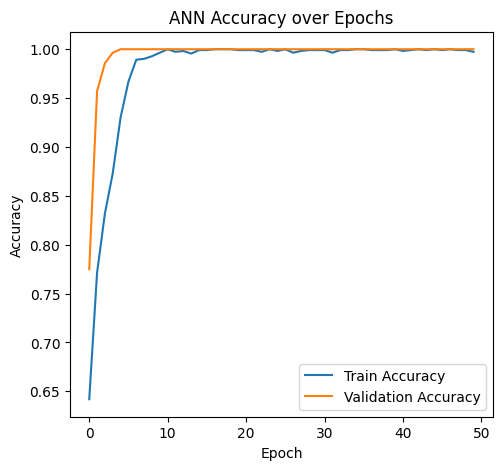

In [ ]:
# ======================= Visualizations =======================
# Accuracy & Loss Curve (ANN)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

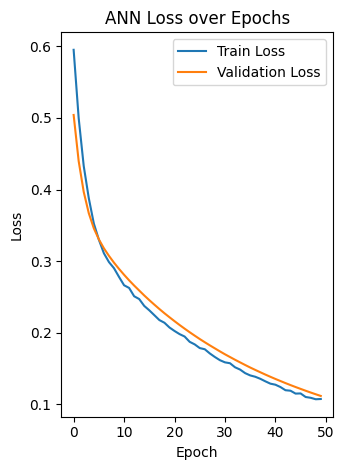

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ANN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

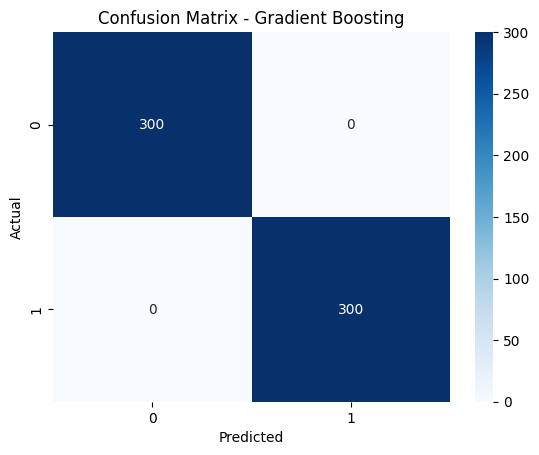

In [ ]:
# Confusion Matrix for Gradient Boosting
cm = confusion_matrix(y_test, gb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

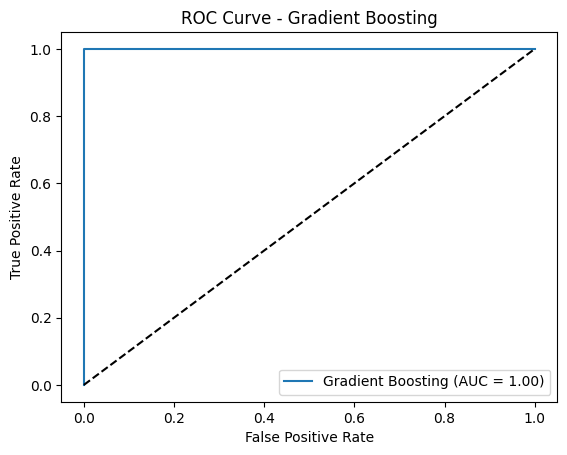

In [ ]:
# ROC Curve for Gradient Boosting
fpr, tpr, _ = roc_curve(y_test, gb_prob)
plt.plot(fpr, tpr, label=f'Gradient Boosting (AUC = {gb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gradient Boosting")
plt.legend()
plt.show()

In [ ]:
# ======================= Fuzzy Logic =======================
rainfall = ctrl.Antecedent(np.arange(0, 300, 1), 'rainfall')
slope = ctrl.Antecedent(np.arange(0, 90, 1), 'slope')
soil_saturation = ctrl.Antecedent(np.arange(0, 1, 0.01), 'soil_saturation')
landslide_risk = ctrl.Consequent(np.arange(0, 1, 0.01), 'landslide_risk')

In [ ]:
rainfall['low'] = fuzz.trimf(rainfall.universe, [0, 50, 100])
rainfall['medium'] = fuzz.trimf(rainfall.universe, [80, 150, 220])
rainfall['high'] = fuzz.trimf(rainfall.universe, [200, 250, 300])

In [ ]:
slope['gentle'] = fuzz.trimf(slope.universe, [0, 15, 30])
slope['moderate'] = fuzz.trimf(slope.universe, [25, 45, 60])
slope['steep'] = fuzz.trimf(slope.universe, [50, 70, 90])

In [ ]:
soil_saturation['low'] = fuzz.trimf(soil_saturation.universe, [0, 0.2, 0.4])
soil_saturation['medium'] = fuzz.trimf(soil_saturation.universe, [0.3, 0.5, 0.7])
soil_saturation['high'] = fuzz.trimf(soil_saturation.universe, [0.6, 0.8, 1])

In [ ]:
landslide_risk['low'] = fuzz.trimf(landslide_risk.universe, [0, 0.2, 0.4])
landslide_risk['medium'] = fuzz.trimf(landslide_risk.universe, [0.3, 0.5, 0.7])
landslide_risk['high'] = fuzz.trimf(landslide_risk.universe, [0.6, 0.8, 1])

In [ ]:
rule1 = ctrl.Rule(rainfall['high'] & slope['steep'] & soil_saturation['high'], landslide_risk['high'])
rule2 = ctrl.Rule(rainfall['medium'] & slope['moderate'] & soil_saturation['medium'], landslide_risk['medium'])
rule3 = ctrl.Rule(rainfall['low'] & slope['gentle'] & soil_saturation['low'], landslide_risk['low'])

In [ ]:
landslide_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
landslide_sim = ctrl.ControlSystemSimulation(landslide_ctrl)

In [ ]:
landslide_sim.input['rainfall'] = 180
landslide_sim.input['slope'] = 45
landslide_sim.input['soil_saturation'] = 0.7
# Crisp output
risk = landslide_sim.output['landslide_risk'] * 100
print(f"Fuzzy Logic Landslide Risk: {risk:.2f}%")

# Get degrees of membership to linguistic terms
low_degree = fuzz.interp_membership(landslide_risk.universe, landslide_risk['low'].mf, risk/100)
medium_degree = fuzz.interp_membership(landslide_risk.universe, landslide_risk['medium'].mf, risk/100)
high_degree = fuzz.interp_membership(landslide_risk.universe, landslide_risk['high'].mf, risk/100)

# Store in dictionary for easy use
membership_dict = {
    'LOW': low_degree,
    'MEDIUM': medium_degree,
    'HIGH': high_degree
}

# Determine the dominant fuzzy label
dominant_label = max(membership_dict, key=membership_dict.get)
dominant_value = membership_dict[dominant_label]

# Print interpretation
print(f"Dominant Fuzzy Category: {dominant_label} (Membership Degree: {dominant_value:.2f})")

Fuzzy Logic Landslide Risk: 50.00%
Dominant Fuzzy Category: MEDIUM (Membership Degree: 1.00)


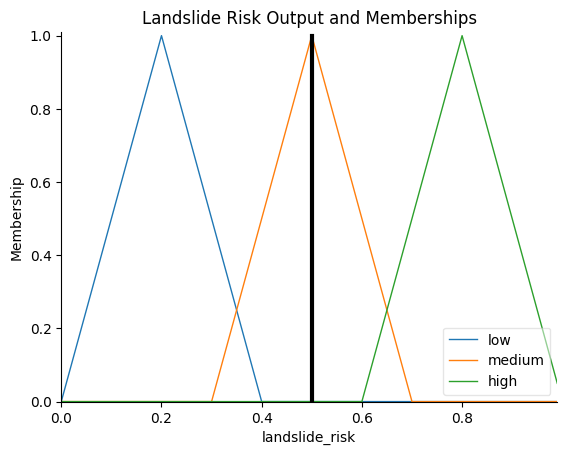

In [ ]:
# Plot membership functions
landslide_risk.view(sim=landslide_sim)
plt.title("Landslide Risk Output and Memberships")
plt.show()